# MNIST Double Layer CNN Classification

**Note**: This notebook is designed to run on GPU runtime.

**[MDL-01]**

Install libraries.

In [ ]:
%%bash
curl -sLO https://raw.githubusercontent.com/enakai00/colab_jaxbook/main/requirements.txt
pip install -qr requirements.txt
pip list | grep -E '(jax|flax|optax)'

flax                          0.6.1
jax                           0.3.21
jaxlib                        0.3.15+cuda11.cudnn805
optax                         0.1.3


**[MDL-02]**

Import modules.

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from pandas import DataFrame
from tensorflow.keras.datasets import mnist
from functools import partial

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state, checkpoints

plt.rcParams.update({'font.size': 12})

**[MDL-03]**

Download the MNIST dataset and store into NumPy arrays.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape([-1, 784]).astype('float32') / 255
test_images = test_images.reshape([-1, 784]).astype('float32') / 255
train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

11490434/11490434 [==============================] - 0s 0us/step


**[MDL-04]**

Define a function to split the dataset into batches.

In [ ]:
def create_batches(data, batch_size):
    num_batches, mod = divmod(len(data), batch_size)
    data_batched = np.split(data[:num_batches * batch_size], num_batches)
    if mod: # Last batch is smaller than batch_size
        data_batched.append(data[num_batches * batch_size:])
    data_batched = [jnp.asarray(x) for x in data_batched]
    return data_batched

**[MDL-05]**

Define a CNN model with dual convolutional filter layers.

In [ ]:
class DoubleLayerCNN(nn.Module):
    @nn.compact
    def __call__(self, x, get_logits=False, eval=True):
        x = x.reshape([-1, 28, 28, 1])

        x = nn.Conv(features=32, kernel_size=(5, 5), use_bias=True)(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = nn.Conv(features=64, kernel_size=(5, 5), use_bias=True)(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = x.reshape([x.shape[0], -1]) # Flatten
        x = nn.Dense(features=1024)(x)
        x = nn.relu(x)

        x = nn.Dropout(0.5, deterministic=eval)(x)

        x = nn.Dense(features=10)(x)
        if get_logits:
            return x
        x = nn.softmax(x)
        return x

**[MDL-06]**

Generate inital parameter values.

In [ ]:
key, key1 = random.split(random.PRNGKey(0))
variables = DoubleLayerCNN().init(
    key1, train_images[0:1], {'dropout': random.PRNGKey(0)})

jax.tree_util.tree_map(lambda x: x.shape, variables['params'])

FrozenDict({
    Conv_0: {
        bias: (32,),
        kernel: (5, 5, 1, 32),
    },
    Conv_1: {
        bias: (64,),
        kernel: (5, 5, 32, 64),
    },
    Dense_0: {
        bias: (1024,),
        kernel: (3136, 1024),
    },
    Dense_1: {
        bias: (10,),
        kernel: (1024, 10),
    },
})

**[MDL-07]**

Create a training state object.

In [ ]:
class TrainState(train_state.TrainState):
    epoch: int
    dropout_rng: type(random.PRNGKey(0))


key, key1 = random.split(key)

state = TrainState.create(
    apply_fn=DoubleLayerCNN().apply,
    params=variables['params'],
    tx=optax.adam(learning_rate=0.001),
    dropout_rng=key1,
    epoch=0)

**[MDL-08]**

Save the initial checkpoint.

In [ ]:
checkpoints.save_checkpoint(
    ckpt_dir='./checkpoints/', prefix='DoubleLayerCNN_checkpoint_', 
    target=state, step=state.epoch, overwrite=True)

'checkpoints/DoubleLayerCNN_checkpoint_0'

**[MDL-09]**

Define a loss function as the categorical cross entoropy.

In [ ]:
@partial(jax.jit, static_argnames=['eval'])
def loss_fn(params, state, inputs, labels, dropout_rng, eval):
    logits = state.apply_fn(
        {'params': params}, inputs, get_logits=True, eval=eval,
        rngs={'dropout': dropout_rng})
    loss = optax.softmax_cross_entropy(logits, labels).mean()
    acc = jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(labels, -1))
    return loss, acc

**[MDL-10]**

Define a function to apply a single training step that returns a new training state.

In [ ]:
@partial(jax.jit, static_argnames=['eval'])
def train_step(state, inputs, labels, eval):
    if not eval:
        new_dropout_rng, dropout_rng = random.split(state.dropout_rng)
        (loss, acc), grads = jax.value_and_grad(loss_fn, has_aux=True)(
            state.params, state, inputs, labels, dropout_rng, eval)
        new_state = state.apply_gradients(
            grads=grads, dropout_rng=new_dropout_rng)
    else:
        loss, acc = loss_fn(
            state.params, state, inputs, labels, random.PRNGKey(0), eval)
        new_state = state

    return new_state, loss, acc

**[MDL-11]**

Define a function to apply the training steps for one epoch.

In [ ]:
def train_epoch(state, input_batched, label_batched, eval):
    loss_history, acc_history = [], []
    for inputs, labels in zip(input_batched, label_batched):
        new_state, loss, acc = train_step(state, inputs, labels, eval)
        if not eval:
            state = new_state
        loss_history.append(jax.device_get(loss).tolist())
        acc_history.append(jax.device_get(acc).tolist())
    return state, np.mean(loss_history), np.mean(acc_history)

**[MDL-12]**

Define a function to repeat the training steps for multiple epochs.

In [ ]:
def fit(state, ckpt_dir, prefix,
        train_inputs, train_labels, test_inputs, test_labels,
        epochs, batch_size):

    state = checkpoints.restore_checkpoint(
        ckpt_dir=ckpt_dir, prefix=prefix, target=state)

    train_inputs_batched = create_batches(train_inputs, batch_size)
    train_labels_batched = create_batches(train_labels, batch_size)
    test_inputs_batched = create_batches(test_inputs, batch_size)
    test_labels_batched = create_batches(test_labels, batch_size)

    loss_history_train, acc_history_train = [], []
    loss_history_test, acc_history_test = [], []

    for epoch in range(state.epoch + 1, state.epoch + 1 + epochs):
        # Training
        state, loss_train, acc_train = train_epoch(
            state, train_inputs_batched, train_labels_batched, eval=False)
        loss_history_train.append(loss_train)
        acc_history_train.append(acc_train)

        # Evaluation
        _ , loss_test, acc_test = train_epoch(
            state, test_inputs_batched, test_labels_batched, eval=True)
        loss_history_test.append(loss_test)
        acc_history_test.append(acc_test)

        print ('Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f} / '.format(
            epoch, loss_train, acc_train), end='', flush=True)
        print ('Loss(Test): {:.4f}, Accuracy(Test): {:.4f}'.format(
            loss_test, acc_test), flush=True)
        
        state = state.replace(epoch=state.epoch+1)
        checkpoints.save_checkpoint(
            ckpt_dir=ckpt_dir, prefix=prefix,
            target=state, step=state.epoch, overwrite=True, keep=5)
  
    history = {'loss_train': loss_history_train,
               'acc_train': acc_history_train,
               'loss_test': loss_history_test,
               'acc_test': acc_history_test}
  
    return state, history

**[MDL-13]**

Repeat the training steps for multiple epochs.

In [ ]:
%%time
ckpt_dir = './checkpoints/'
prefix = 'DoubleLayerCNN_checkpoint_'
state, history = fit(state, ckpt_dir, prefix,
                     train_images, train_labels, test_images, test_labels,
                     epochs=16, batch_size=128)

Epoch: 1, Loss: 0.1425, Accuracy: 0.9555 / Loss(Test): 0.0461, Accuracy(Test): 0.9840
Epoch: 2, Loss: 0.0453, Accuracy: 0.9862 / Loss(Test): 0.0253, Accuracy(Test): 0.9907
Epoch: 3, Loss: 0.0293, Accuracy: 0.9909 / Loss(Test): 0.0267, Accuracy(Test): 0.9908
Epoch: 4, Loss: 0.0226, Accuracy: 0.9929 / Loss(Test): 0.0275, Accuracy(Test): 0.9916
Epoch: 5, Loss: 0.0169, Accuracy: 0.9946 / Loss(Test): 0.0257, Accuracy(Test): 0.9922
Epoch: 6, Loss: 0.0140, Accuracy: 0.9953 / Loss(Test): 0.0284, Accuracy(Test): 0.9925
Epoch: 7, Loss: 0.0123, Accuracy: 0.9960 / Loss(Test): 0.0311, Accuracy(Test): 0.9904
Epoch: 8, Loss: 0.0095, Accuracy: 0.9970 / Loss(Test): 0.0303, Accuracy(Test): 0.9927
Epoch: 9, Loss: 0.0083, Accuracy: 0.9972 / Loss(Test): 0.0345, Accuracy(Test): 0.9923
Epoch: 10, Loss: 0.0101, Accuracy: 0.9969 / Loss(Test): 0.0305, Accuracy(Test): 0.9922
Epoch: 11, Loss: 0.0083, Accuracy: 0.9972 / Loss(Test): 0.0306, Accuracy(Test): 0.9913
Epoch: 12, Loss: 0.0061, Accuracy: 0.9979 / Loss(Tes

**[MDL-14]**

Show charts of the accuracy history and the loss history.

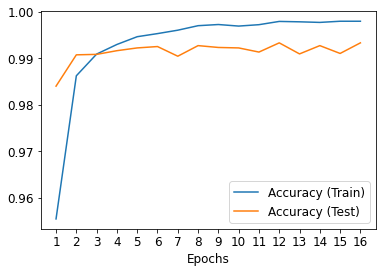

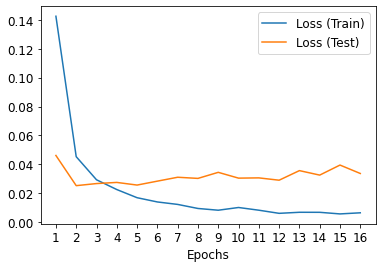

In [ ]:
df = DataFrame({'Accuracy (Train)': history['acc_train'],
                'Accuracy (Test)': history['acc_test']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(6, 4))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'Loss (Train)': history['loss_train'],
                'Loss (Test)': history['loss_test']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(6, 4))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

**[MDL-15]**

List the checkpoint files.

In [ ]:
!ls -lh ./checkpoints/

total 188M
-rw-r--r-- 1 root root 38M Oct 23 23:24 DoubleLayerCNN_checkpoint_12
-rw-r--r-- 1 root root 38M Oct 23 23:24 DoubleLayerCNN_checkpoint_13
-rw-r--r-- 1 root root 38M Oct 23 23:24 DoubleLayerCNN_checkpoint_14
-rw-r--r-- 1 root root 38M Oct 23 23:24 DoubleLayerCNN_checkpoint_15
-rw-r--r-- 1 root root 38M Oct 23 23:24 DoubleLayerCNN_checkpoint_16


**[MDL-16]**

Mount Google Drive content.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**[MDL-17]**

Save a TrainState checkpoint file.

In [ ]:
checkpoints.save_checkpoint(
    ckpt_dir='/content/gdrive/My Drive/checkpoints/',
    prefix='DoubleLayerCNN_checkpoint_',
    target=state, step=state.epoch, overwrite=True)

'/content/gdrive/My Drive/checkpoints/DoubleLayerCNN_checkpoint_16'

**[MDL-18]**

Check filesize of the checkpoint file.

In [ ]:
!ls -lh '/content/gdrive/My Drive/checkpoints/'

total 75M
-rw------- 1 root root 38M Oct 23 23:25 DoubleLayerCNN_checkpoint_16
-rw------- 1 root root 37M Oct 23 23:20 SingleLayerCNN_checkpoint_16
